In [1]:
from keras.layers import Input, Dense
from keras.models import Model, Sequential
from keras.datasets import mnist
import numpy as np
import pandas as pd
from IPython.display import display

from sklearn.model_selection import train_test_split

# use Matplotlib (don't ask)
import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.


## Load Data

In [2]:
data_df = pd.read_pickle('MIMIC_Dataset_20Aug2017.pkl')

display(data_df.head(5))

,CCS_CATEGORY,PRC_995,PRC_389,PRC_896,PRC_960,PRC_966,PRC_967,PRC_996,PRC_332,PRC_887,...,URGENT,PHYS REFERRAL/NORMAL DELI,EMERGENCY ROOM ADMIT,TRANSFER FROM HOSP/EXTRAM,CLINIC REFERRAL/PREMATURE,TRANSFER FROM OTHER HEALT,TRANSFER FROM SKILLED NUR,HMO REFERRAL/SICK,** INFO NOT AVAILABLE **,TRSF WITHIN THIS FACILITY
SUBJECT_ID,,,,,,,,,,,,,,,,,,,,,
2,218,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2,0.0,0.166667,0.166667,0.166667,0.166667,0.166667,0.166667,0.000000,0.000000,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,5,0.0,0.333333,0.000000,0.000000,0.000000,0.000000,0.000000,0.333333,0.333333,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,218,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,99,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [3]:
X = data_df.iloc[:,2:].as_matrix()
y = data_df['CCS_CATEGORY'].tolist()
print(type(X),X.shape)
print(type(y),len(y))
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)



(<type 'numpy.ndarray'>, (53638, 3764))
(<type 'list'>, 53638)


In [ ]:
# Show Format of CCS_Category
print(y_test)

## Create Autoencoder in Keras (NOTE: Weights not tied)

In [4]:
input_dim    = x_train.shape[1]
encoding_dim = 500


# this is our input placeholder
iLayer1 = Input(shape=(input_dim,))

# "encoded" is the encoded representation of the input
hLayer1 = Dense(encoding_dim, activation='relu', kernel_initializer='glorot_normal')(iLayer1)
hLayer2 = Dense(encoding_dim, activation='relu', kernel_initializer='glorot_normal')(hLayer1)
hLayer3 = Dense(encoding_dim, activation='relu', kernel_initializer='glorot_normal')(hLayer2)

# "decoded" is the lossy reconstruction of the input
oLayer4 = Dense(input_dim, activation='sigmoid')(hLayer3)

# this model maps an input to its reconstruction
StackedAutoencoder = Model(iLayer1, oLayer4)

# this model maps an input to its reconstruction
Embedding = Model(iLayer1, hLayer3)

# Create a mapping to the individual autoencoders layers
iLayer2 = Input(shape=(encoding_dim,))
iLayer3 = Input(shape=(encoding_dim,))

# Create Placeholders for the Encoding for each autoencoder 
eLayer1 = StackedAutoencoder.layers[1](iLayer1)
eLayer2 = StackedAutoencoder.layers[2](iLayer2)
eLayer3 = StackedAutoencoder.layers[3](iLayer3)

# Create Placeholders for the Decoding for each autoencoder
dLayer1 = Dense(input_dim, activation='relu')(eLayer1)
dLayer2 = Dense(encoding_dim, activation='relu')(eLayer2)
dLayer3 = Dense(encoding_dim, activation='relu')(eLayer3)

# Store the Encoders
Encoder1 = Model(iLayer1, eLayer1)
Encoder2 = Model(iLayer2, eLayer2)
Encoder3 = Model(iLayer3, eLayer3)

# Store the Decoders
Autoencoder1 = Model(iLayer1, dLayer1)
Autoencoder2 = Model(iLayer2, dLayer2)
Autoencoder3 = Model(iLayer3, dLayer3)

# Compile models
Autoencoder1.compile(optimizer='adadelta', loss='binary_crossentropy')
Autoencoder2.compile(optimizer='adadelta', loss='binary_crossentropy')
Autoencoder3.compile(optimizer='adadelta', loss='binary_crossentropy')

StackedAutoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')

## Train the Stacked Autoencoder, first layer wise, and then fine tuen the entire network

In [5]:

#add noise
nf = 0.05
mask = np.random.choice([0,1],size=x_train.shape, p=[nf,1-nf])


Autoencoder1.fit(x_train*mask, x_train,
            epochs=25,
            batch_size=256,
            shuffle=True,
            validation_data=(x_test, x_test))
    
train_data = Encoder1.predict(x_train)
test_data = Encoder1.predict(x_test)

mask = np.random.choice([0,1],size=train_data.shape, p=[nf,1-nf])
Autoencoder2.fit(train_data*mask, train_data,
            epochs=25,
            batch_size=256,
            shuffle=True,
            validation_data=(test_data, test_data))
    
train_data = Encoder2.predict(train_data)
test_data = Encoder2.predict(test_data)

mask = np.random.choice([0,1],size=train_data.shape, p=[nf,1-nf])
Autoencoder3.fit(train_data*mask, train_data,
            epochs=25,
            batch_size=256,
            shuffle=True,
            validation_data=(test_data, test_data))

# Fine Tune Full model
mask = np.random.choice([0,1],size=x_train.shape, p=[nf,1-nf])
StackedAutoencoder.fit(x_train*mask, x_train,
                        epochs=50,
                        batch_size=256,
                        shuffle=True,
                        validation_data=(x_test, x_test))    

Train on 35937 samples, validate on 17701 samples
Epoch 1/25
35937/35937 [==============================] - 8s - loss: 0.0184 - val_loss: 0.0151
Epoch 2/25
35937/35937 [==============================] - 4s - loss: 0.0143 - val_loss: 0.0137
Epoch 3/25
35937/35937 [==============================] - 4s - loss: 0.0134 - val_loss: 0.0131
Epoch 4/25
35937/35937 [==============================] - 4s - loss: 0.0129 - val_loss: 0.0127
Epoch 5/25
35937/35937 [==============================] - 4s - loss: 0.0126 - val_loss: 0.0124
Epoch 6/25
35937/35937 [==============================] - 4s - loss: 0.0124 - val_loss: 0.0122
Epoch 7/25
35937/35937 [==============================] - 4s - loss: 0.0122 - val_loss: 0.0120
Epoch 8/25
35937/35937 [==============================] - 4s - loss: 0.0120 - val_loss: 0.0119
Epoch 9/25
35937/35937 [==============================] - 4s - loss: 0.0119 - val_loss: 0.0118
Epoch 10/25
35937/35937 [==============================] - 4s - loss: 0.0118 - val_loss: 0.0116

35937/35937 [==============================] - 4s - loss: 0.0104 - val_loss: 0.0104
Epoch 10/50
35937/35937 [==============================] - 4s - loss: 0.0104 - val_loss: 0.0104
Epoch 11/50
35937/35937 [==============================] - 4s - loss: 0.0104 - val_loss: 0.0103
Epoch 12/50
35937/35937 [==============================] - 4s - loss: 0.0104 - val_loss: 0.0103
Epoch 13/50
35937/35937 [==============================] - 4s - loss: 0.0104 - val_loss: 0.0103
Epoch 14/50
35937/35937 [==============================] - 4s - loss: 0.0104 - val_loss: 0.0103
Epoch 15/50
35937/35937 [==============================] - 4s - loss: 0.0103 - val_loss: 0.0103
Epoch 16/50
35937/35937 [==============================] - 4s - loss: 0.0103 - val_loss: 0.0103
Epoch 17/50
35937/35937 [==============================] - 4s - loss: 0.0103 - val_loss: 0.0103
Epoch 18/50
35937/35937 [==============================] - 4s - loss: 0.0103 - val_loss: 0.0103
Epoch 19/50
35937/35937 [===========================

In [7]:
# encode and decode some digits
# note that we take them from the *test* set
decoded = StackedAutoencoder.predict(x_test)

## Apply a Random Forest Classifier

In [8]:
xe_test = Embedding.predict(x_test)
xe_train = Embedding.predict(x_train)
print(xe_test.shape)
print(xe_train.shape)
print(len(np.unique(y_test)))
print(len(np.unique(y_train)))

(17701, 500)
(35937, 500)
72
72


In [9]:
from sklearn.datasets import make_multilabel_classification
from sklearn.multiclass import OneVsRestClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import label_binarize


from sklearn import metrics
from matplotlib import cm

print("Training Model")
# Use label_binarize to be multi-label like settings
y_train = np.asarray(y_train,int)
y_test =  np.asarray(y_test,int)

Y_train_bin = label_binarize(y_train, classes=np.sort(np.unique(y_train)))
Y_test_bin = label_binarize(y_test, classes=np.sort(np.unique(y_test)))

n_classes = Y_train_bin.shape[1]


clf = OneVsRestClassifier(RandomForestClassifier(n_estimators=100, random_state=0,class_weight ='balanced'))
clf.fit(xe_train, Y_train_bin)


print("Training Complete")
 

#print("")
#plt.plot(clf.feature_importances_)


Training Model
1 loop, best of 3: 29min 33s per loop
Training Complete



AttributeError: 'OneVsRestClassifier' object has no attribute 'feature_importances_'

In [14]:
import joblib
# Save Classifier
filename = 'deep_patient_classifier.joblib'
joblib.dump(clf, filename, compress=9)

['deep_patient_classifier.joblib']

In [15]:
y_pred = clf.predict(xe_test)
y_score = clf.predict_proba(xe_test)

In [42]:
print(y_pred.shape)
print(y_score.shape)
print(Y_test_bin.shape)
print(y_test.shape)
print(n_classes)

print(Y_test_bin[:2], y_test[:2])

(17701, 72)
(17701, 72)
(17701, 72)
(17701,)
72
(array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0]]), array([149, 101]))


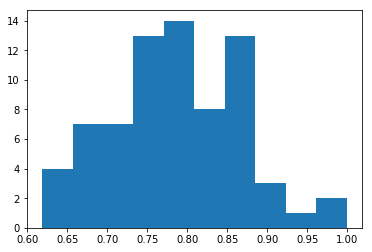

[ 0  2  6 17 20 21 36 38 56 58 60]
[58, 6, 60, 2, 36, 38, 20, 0, 21, 17, 56]
[[ 0.91834844]
 [ 0.65477718]
 [ 0.62367991]
 [ 0.92435847]
 [ 0.89682714]
 [ 0.92294805]
 [ 0.88099485]
 [ 0.88449426]
 [ 0.97626646]
 [ 0.61881483]
 [ 0.63748782]]
[[ 0.61881483]
 [ 0.62367991]
 [ 0.63748782]
 [ 0.65477718]
 [ 0.88099485]
 [ 0.88449426]
 [ 0.89682714]
 [ 0.91834844]
 [ 0.92294805]
 [ 0.92435847]
 [ 0.97626646]]


In [76]:
from sklearn.metrics import roc_curve, auc, accuracy_score, recall_score

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
roc_auc2 = np.zeros((n_classes,1))
css_code = np.zeros((n_classes,1))
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(Y_test_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    roc_auc2[i] = auc(fpr[i], tpr[i])
    css_code[i] = i

    
# Compute micro-average ROC curve and ROC area
#fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
#roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

plt.figure()
plt.hist(roc_auc2)
plt.show()

#find indices for top 10 AUC


css_codes = np.array([ j for (i,j) in zip(roc_auc2,range(n_classes)) if (i >= 0.88 and i<0.99) or (i >= 0.6 and i<0.67) ])
css_codes_sorted = [j for _,j in sorted(zip(roc_auc2[css_codes],css_codes))]

print(css_codes)
print(css_codes_sorted)

#print(css_codes_sorted)

print(roc_auc2[css_codes])
print(roc_auc2[css_codes_sorted])
display()

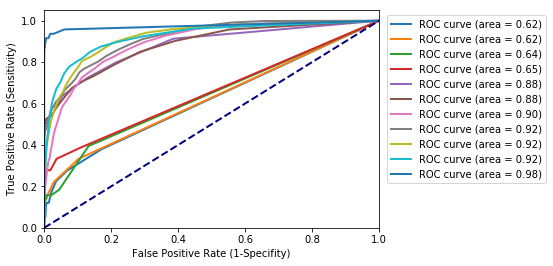

In [79]:
plt.figure()
lw = 2

roc_auc
for i in css_codes_sorted:
    plt.plot(fpr[i], tpr[i], 
             lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[i])
    
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (1-Specifity)')
plt.ylabel('True Positive Rate (Sensitivity)')
#plt.legend(loc="outter right")
plt.legend(bbox_to_anchor=(1.01, 1), loc='upper left')
plt.show()

## Debug Code
### Make sure layer weights agree, showing that models are linked

In [271]:
print("Layer 1")
print(StackedAutoencoder.layers[1].get_weights()[0].mean())
print("")
print(Autoencoder1.layers[1].get_weights()[0].mean())
print("")
print(Encoder1.layers[1].get_weights()[0].mean())
print("")


print("Layer 2")
print(StackedAutoencoder.layers[2].get_weights()[0].mean())
print("")
print(Autoencoder2.layers[1].get_weights()[0].mean())
print("")
print(Encoder2.layers[1].get_weights()[0].mean())
print("")

print("Layer 3")
print(StackedAutoencoder.layers[3].get_weights()[0].mean())
print("")
print(Autoencoder3.layers[1].get_weights()[0].mean())
print("")
print(Encoder3.layers[1].get_weights()[0].mean())
print("")

Layer 1
0.00529846

0.00529846

0.00529846

Layer 2
0.020935

0.020935

0.020935

Layer 3
0.0176379

0.0176379

0.0176379

